# COMP90084 Workshop Week 7
In this week's workshop, we'll program the algorithms we encountered during the lectures last week.

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace, DensityMatrix, Statevector
%matplotlib inline
# shots simulation
backend_sim = Aer.get_backend('qasm_simulator')
# statevector
backend_sv = Aer.get_backend('statevector_simulator')

## Grover's Algorithm
In this section, we will program a 3-qubit Grover's algorithm. The phase oracle will be marking the state $|101\rangle$ and $|110\rangle$. We won't be using ancilla qubits to mark the phase, controlled-Z rotation will be enough:

![3-qubit Grover's Algorithm, from Qiskit Textbook](https://qiskit.org/textbook/ch-algorithms/images/grover_circuit_3qubits.png)

<ol>
<li> 
  Apply Hadamard gates to $3$ qubits initialized to $\lvert000\rangle$ to create a uniform superposition:
  $$\lvert \psi_1 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle \right) $$
</li>

<li>
  Mark states $\lvert101\rangle$ and $\lvert110\rangle$ using a phase oracle:
  $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle - \lvert101\rangle - \lvert110\rangle + \lvert111\rangle \right) $$
</li>

<li>
  Perform the reflection around the average amplitude:
    
  <ol>
   <li> Apply Hadamard gates to the qubits
      $$\lvert \psi_{3a} \rangle = \frac{1}{2} \left( 
        \lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
    
   <li> Apply X gates to the qubits
      $$\lvert \psi_{3b} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle +\lvert111\rangle \right) $$
   </li>

   <li> Apply a doubly controlled Z gate between the 1, 2 (controls) and 3 (target) qubits
      $$\lvert \psi_{3c} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
   <li> Apply X gates to the qubits
      $$\lvert \psi_{3d} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
   <li> Apply Hadamard gates to the qubits
      $$\lvert \psi_{3e} \rangle = \frac{1}{\sqrt{2}} \left( 
        -\lvert101\rangle -\lvert110\rangle \right) $$
   </li>
  </ol>
</li>

<li>
  Measure the $3$ qubits to retrieve states $\lvert101\rangle$ and $\lvert110\rangle$
</li>
</ol>

Note that since there are 2 solutions and 8 possibilities, we will only need to run one iteration (steps 2 & 3).


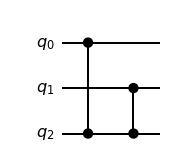

In [2]:
# First, we'll need to construct an oracle to mark states |101> and |110>
# Since the ordering of qubits in Qiskit is reversed
# we'll only need CZ gates between qubits 0&2 and 1&2
qc = QuantumCircuit(3)
### YOUR CODE STARTS HERE
qc.cz(0, 2)
qc.cz(1, 2)
### YOUR CODE ENDS HERE
oracle = qc.to_gate()
oracle.name = "Oracle"
qc.draw('mpl', style = "bw")

In [3]:
# created a general diffuser
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    ### YOUR CODE STARTS HERE
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.barrier()
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    qc.barrier()
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    ### YOUR CODE ENDS HERE
    
    return qc

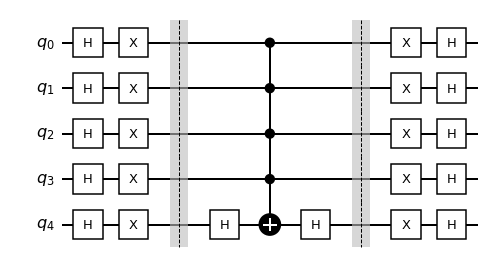

In [4]:
example_diffuser = diffuser(5)
example_diffuser.draw('mpl', style='bw')

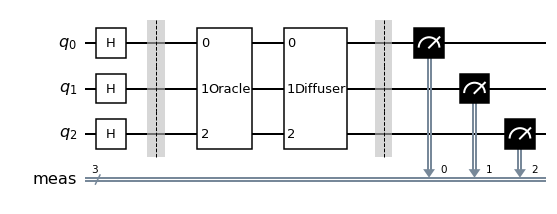

In [5]:
n = 3
diffu = diffuser(n).to_instruction()
diffu.name = 'Diffuser'
grover_circuit = QuantumCircuit(n)
### YOUR CODE STARTS HERE
for i in range(n):
    grover_circuit.h(i)
grover_circuit.barrier()
grover_circuit.append(oracle, [0,1,2])
grover_circuit.append(diffu, [0,1,2])
### YOUR CODE ENDS HERE
grover_circuit.measure_all()
grover_circuit.draw('mpl', style='bw')

{'101': 2052, '110': 2044}


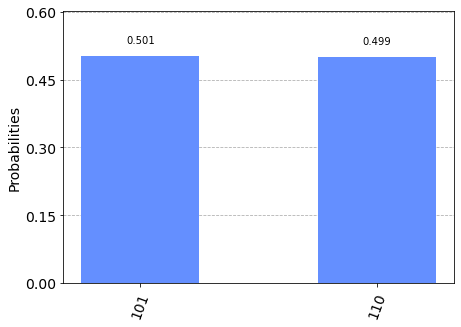

In [6]:
# simulate the circuit
job = backend_sim.run(transpile(grover_circuit, backend_sim), shots=4096)
result = job.result()
counts = result.get_counts(grover_circuit)
print(counts)
plot_histogram(counts)

## Simon's Algorithm

For this task, we set b = 110 for $f(x\oplus b) = f(x)$.

In [15]:
# a helper function to create the oracle for Simon's algorithm
# from https://github.com/qiskit-community/qiskit-textbook/blob/main/qiskit-textbook-src/qiskit_textbook/tools/__init__.py#L26
def simon_oracle(b):
    """returns a Simon oracle for bitstring b"""
    b = b[::-1] # reverse b for easy iteration
    n = len(b)
    qc = QuantumCircuit(n*2)
    # Do copy; |x>|0> -> |x>|x>
    for q in range(n):
        qc.cx(q, q+n)
    if '1' not in b: 
        return qc  # 1:1 mapping, so just exit
    i = b.find('1') # index of first non-zero bit in b
    # Do |x> -> |s.x> on condition that q_i is 1
    for q in range(n):
        if b[q] == '1':
            qc.cx(i, (q)+n)
    return qc 

# a helper function to calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

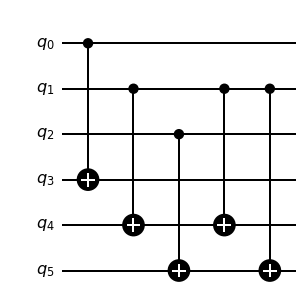

/tmp/ipykernel_299/31569311.py:10: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  simon_circuit+=simon_oracle(b)


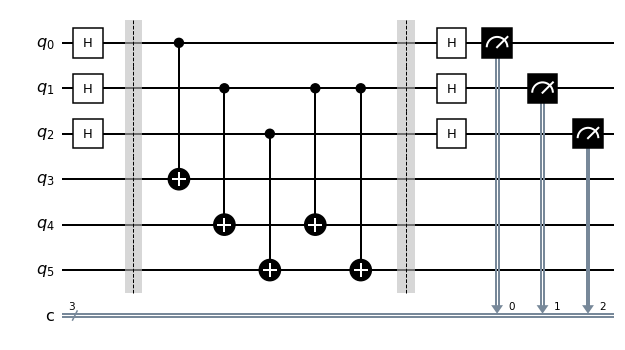

In [14]:
b = '110'
n = len(b)

display(simon_oracle(b).draw('mpl', style='bw'))
simon_circuit = QuantumCircuit(n*2, n)

### YOUR CODE STARTS HERE
simon_circuit.h(range(n))
simon_circuit.barrier()
simon_circuit+=simon_oracle(b)
simon_circuit.barrier()
simon_circuit.h(range(n))
simon_circuit.measure(range(n), range(n))
### YOUR CODE ENDS HERE
simon_circuit.draw('mpl', style='bw')

{'000': 991, '110': 1067, '001': 1041, '111': 997}


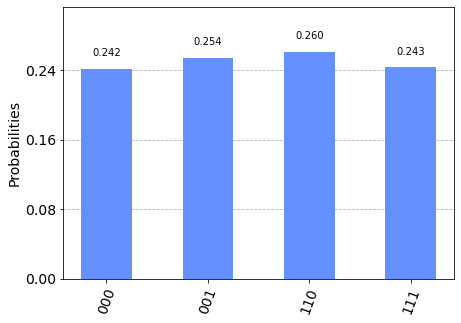

In [16]:
# simulate the circuit
job = backend_sim.run(transpile(simon_circuit, backend_sim), shots=4096)
result = job.result()
counts = result.get_counts(simon_circuit)
print(counts)
plot_histogram(counts)

In [17]:
for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

110.000 = 0 (mod 2)
110.110 = 0 (mod 2)
110.001 = 0 (mod 2)
110.111 = 0 (mod 2)
